# Recommendation & Accuracy 

GOALS:::

Recommendation Strategies
1. k constant: recommend with k many papers
2. k parameter: threshold on the papers

Evaluation Strategies
1. Accuracy metrics
2. Discovery-oriented metrics
"""


# Example

In [1]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../../')
import random
import preprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from collections import defaultdict
%matplotlib inline
from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)
from surprise import SVD, SVDpp, NMF
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split, cross_validate,  KFold


### Below tic toc from https://stackoverflow.com/questions/5849800/tic-toc-functions-analog-in-python
import time
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

###all rights to below for these functions
###http://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def precision_recall_at_k(est_mat, items_in_trainset_of_users_in_testset, true_r, k=10, threshold=3.5,how_many_zeros=False):
    '''Return precision and recall at k metrics for each user.'''


    users = items_in_trainset_of_users_in_testset.keys()
    precisions = dict()
    recalls = dict()
    how_many_zero_prec = 0
    how_many_zero_recall=0
    
    for user in users:
        all_est = est_mat[user]
        items_to_be_ignored = [item for item,rating in items_in_trainset_of_users_in_testset[user]]
        ests = [all_est[k] for k in range(len(all_est)) if k not in items_to_be_ignored]
        ests = np.array(ests)
        idx = np.argsort(-ests)
        sorted_ests = ests[idx]
        
        true_ratings = np.zeros(len(all_est))
        for k in range(len(true_ratings)):
            if k in true_r[user].keys():
                true_ratings[k] = true_r[user][k]
        sorted_ratings = true_ratings[idx]
        
        n_rel = sum(sorted_ratings > threshold)
        if n_rel==0:
            how_many_zero_recall += 1
        n_rec_k = sum((est > threshold) for est in sorted_ests[:k]) 
        if n_rec_k == 0:
            how_many_zero_prec += 1
        idx_n_rel_k = [rat > threshold for rat in sorted_ratings[:k]]
        top_k_ests = sorted_ests[:k]
        n_rel_and_rec_k = sum((est>threshold) for est in top_k_ests[idx_n_rel_k])
        precisions[user] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[user] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
    if how_many_zeros == False:
        return precisions, recalls
    else:
        return precisions, recalls, how_many_zero_prec, how_many_zero_recall

# Recommendation System
## 1. SVD(biased=False)
### 1.1 Hyperparameter search


In [64]:
random_dict = preprocess.create_random_subset_user_paper_data(size= 4000,debug=True)
trainset, testset = preprocess.user_paper_train_test_split(random_dict, test_size = .15)
rating_scale = (1,11)
trainset = preprocess.create_surprise_user_paper_data(trainset, rating_scale).build_full_trainset()
testset = preprocess.create_surprise_user_paper_data(testset, rating_scale).build_full_trainset().build_testset()

In [109]:
# Regularization Hyperparameter Search 1.
lambdas = 10.0**np.arange(-10,1)
test_loss_possible_rmse = np.zeros(len(lambdas))

for i in range(len(lambdas)):
    algo = SVD(biased=False, n_epochs = 200,reg_all=lambdas[i])
    algo.fit(trainset)
    predictions = algo.test(testset, clip=False)
    possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
    test_loss_possible_rmse[i] = accuracy.rmse(possible_predictions,verbose=False)

hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi


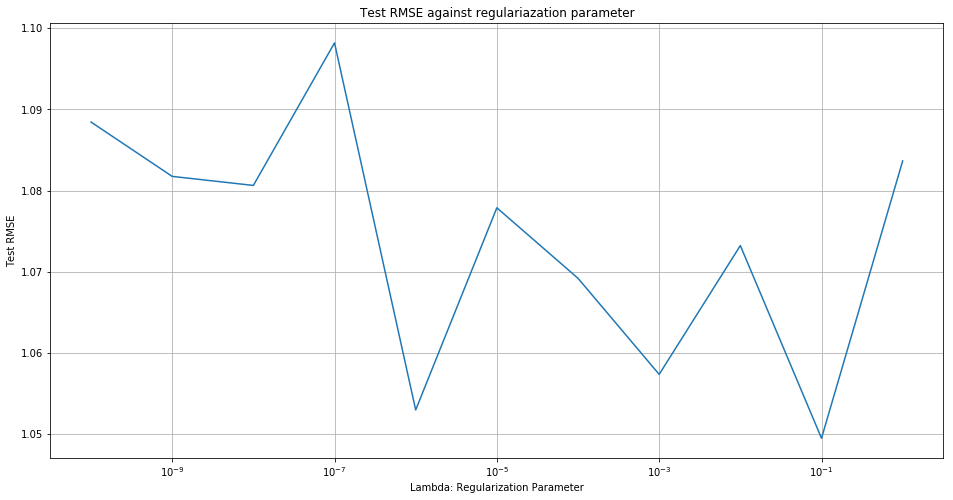

In [110]:
plt.semilogx(lambdas,test_loss_possible_rmse)
plt.title('Test RMSE against regulariazation parameter')
plt.xlabel('Lambda: Regularization Parameter')
plt.ylabel('Test RMSE')
plt.grid()
plt.savefig('svdfalsetestrmselambda.eps',format='eps')
# best lambda = 10^-1

In [100]:
# hyperparameter search 2: test rmse against rank
nnn_factors = np.linspace(10,150,15)
test_loss_possible_rmse = np.zeros(len(nnn_factors))
test_loss_all_rmse = np.zeros(len(nnn_factors))
test_loss_possible_mae = np.zeros(len(nnn_factors))
test_loss_all_mae = np.zeros(len(nnn_factors))

for i in range(len(nnn_factors)):
    algo = SVD(biased=False, n_epochs = 100,reg_all=10**(-1),n_factors=int(nnn_factors[i]))
    algo.fit(trainset)
    predictions = algo.test(testset, clip=False)
    possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
    test_loss_possible_rmse[i] = accuracy.rmse(possible_predictions,verbose=False)
#     test_loss_all_rmse[i] = accuracy.rmse(predictions,verbose=False)
#     test_loss_possible_mae[i] = accuracy.mae(possible_predictions,verbose=False)
#     test_loss_all_mae[i] = accuracy.mae(predictions,verbose=False)

hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi


2

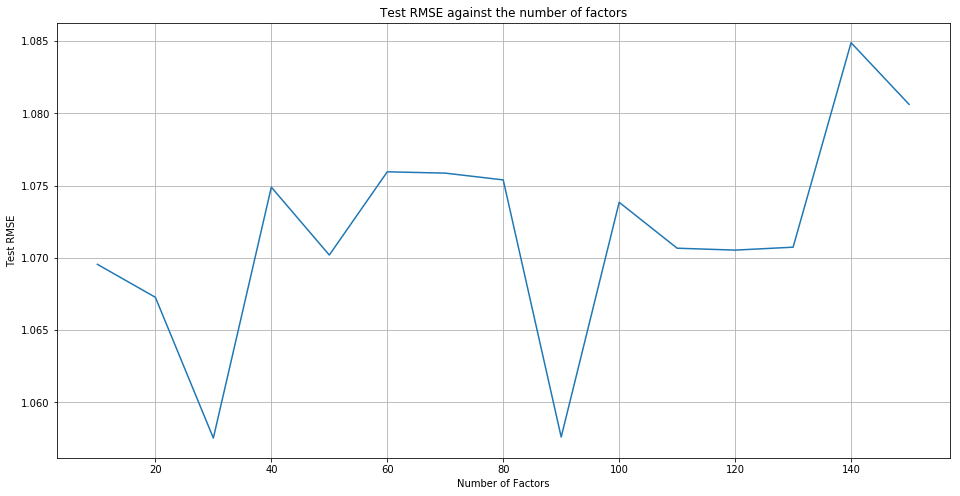

In [101]:
plt.plot(nnn_factors,test_loss_possible_rmse)
plt.title('Test RMSE against the number of factors')
plt.xlabel('Number of Factors')
plt.ylabel('Test RMSE')
plt.grid()
plt.savefig('svdfalsetestrmserank.eps',format='eps')
np.argmin(test_loss_possible_rmse)
# minimum at n_factors = 40.

In [72]:
# lambda = 10^-1 and n_factors = 40 works best for all four accuracies.
# Set reg_all = 10^-1, and n_factors = 40.
# Now let's do precision and recall.
algo = SVD(biased=False, n_epochs = 100,reg_all=10**(-1),n_factors=40)
algo.fit(trainset)
predictions = algo.test(testset, clip=False)
possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
    

hihihihihihi


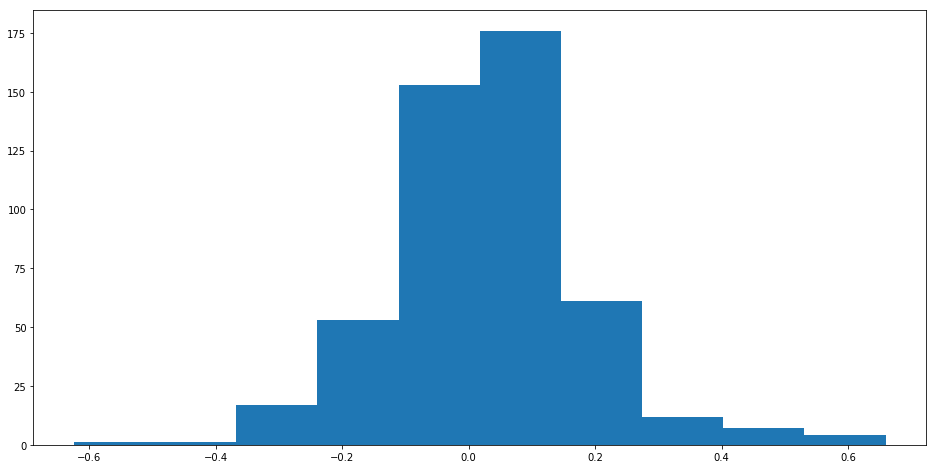

(0.027998046827016378, 0.15392959182074628, 0.6594933574884643, 485, 2879)

In [73]:
"""
Estimation is a gaussian distribution.
Below is a histogram of estimations.
"""
estimations = []
for idx in range(len(possible_predictions)):
    estimations.append(possible_predictions[idx].est)

plt.hist(estimations,bins=10)
plt.show()

np.mean(estimations),np.std(estimations),max(estimations),len(estimations),len(random_dict)


### 1.2 Precision and Recall


In [81]:
# total ratings = 9507
U = 2879
I = 7937
est_mat = np.zeros((U,I))
for u in range(U):
    for i in range(I):
        est_mat[u][i] = algo.estimate(u,i)

In [82]:
users_testset = set()
for user,_,_ in testset:
    users_testset.add(user)
items_in_trainset_of_users_in_testset = defaultdict(list)
for user in users_testset:
    items_in_trainset_of_users_in_testset[trainset.to_inner_uid(user)] = trainset.ur[trainset.to_inner_uid(user)]
    
true_r = defaultdict(partial(defaultdict, int))
for user, paper, rating in testset:
    try:
        true_r[trainset.to_inner_uid(user)][trainset.to_inner_iid(paper)] = rating
    except ValueError:
        pass

In [90]:
k = 40
thresholds = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4]
precision_hist = np.zeros(len(thresholds))
recall_hist = np.zeros(len(thresholds))
f1_hist = np.zeros(len(thresholds))
for t,threshold in enumerate(thresholds):
    precisions_possible, recalls_possible = precision_recall_at_k(est_mat, items_in_trainset_of_users_in_testset, true_r, k=k, threshold=threshold)
    precision_hist[t] = sum(prec for prec in precisions_possible.values()) / len(precisions_possible)
    recall_hist[t] = sum(rec for rec in recalls_possible.values()) / len(recalls_possible)
    f1_hist[t] = 2*(precision_hist[t]*recall_hist[t])/(precision_hist[t]+recall_hist[t])

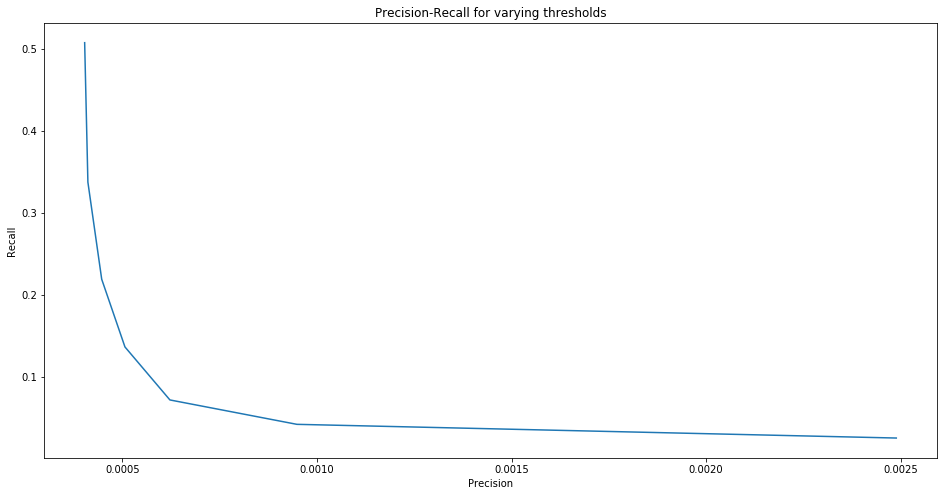

In [91]:
plt.plot(precision_hist[:7],recall_hist[:7])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall for varying thresholds')
plt.savefig('precrecsvdfalse.eps',format='eps')

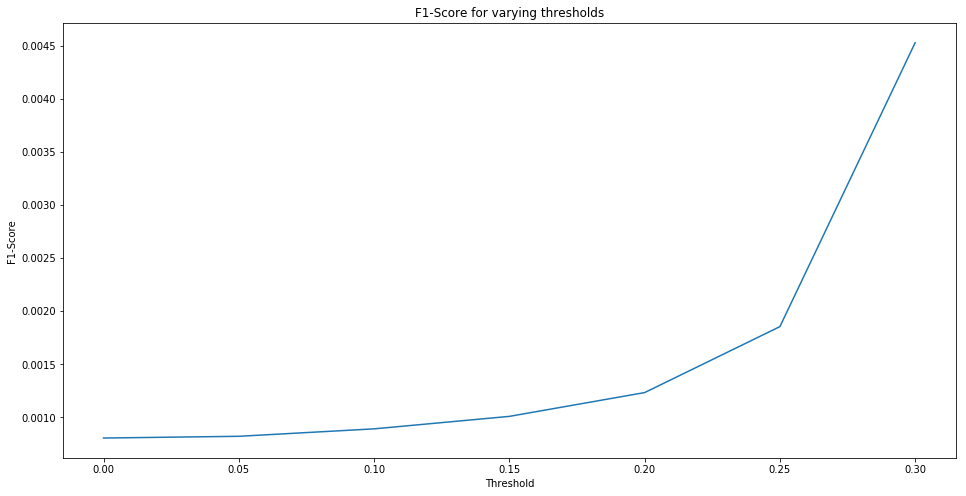

In [96]:
plt.plot(thresholds[:7],f1_hist[:7])
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score for varying thresholds')
plt.savefig('f1scoresvdfalse.eps',format='eps')

## 2. SVD(biased=True)
### 2.1 HyperParam. Search

In [102]:
random_dict = preprocess.create_random_subset_user_paper_data(size= 4000,debug=True)
trainset, testset = preprocess.user_paper_train_test_split(random_dict, test_size = .15)
rating_scale = (1,11)
trainset = preprocess.create_surprise_user_paper_data(trainset, rating_scale).build_full_trainset()
testset = preprocess.create_surprise_user_paper_data(testset, rating_scale).build_full_trainset().build_testset()

In [148]:
# Regularization Hyperparameter Search 1.
lambdas = 10.0**np.arange(-10,3)
test_loss_possible_rmse = np.zeros(len(lambdas))

for i in range(len(lambdas)):
    algo = SVD(biased=True, n_epochs = 300,reg_all=lambdas[i])
    algo.fit(trainset)
    predictions = algo.test(testset, clip=False)
    possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
    test_loss_possible_rmse[i] = accuracy.rmse(possible_predictions,verbose=False)

hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi


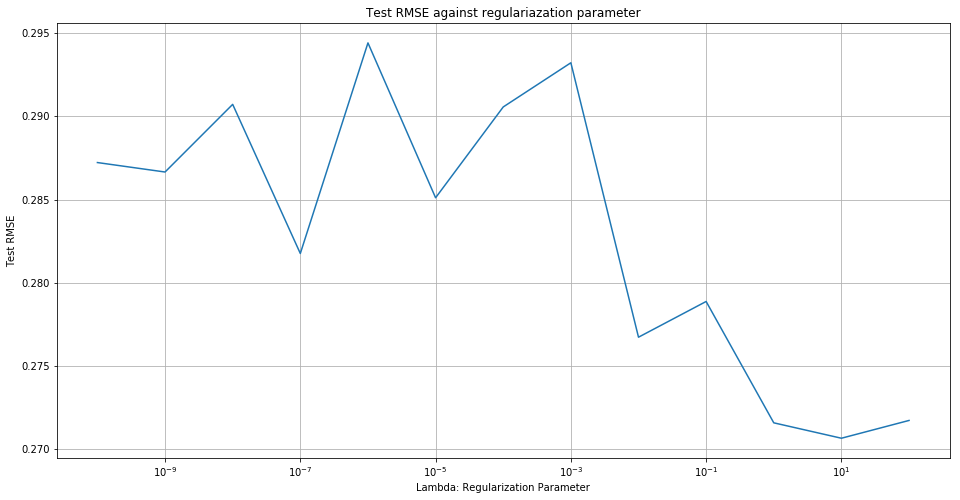

In [150]:
plt.semilogx(lambdas,test_loss_possible_rmse)
plt.title('Test RMSE against regulariazation parameter')
plt.xlabel('Lambda: Regularization Parameter')
plt.ylabel('Test RMSE')
plt.grid()
# plt.savefig('svdtruetestrmselambda.eps',format='eps')
# best lambda = 10

In [114]:
# hyperparameter search 2: test rmse against rank
nnn_factors = np.linspace(10,150,15)
test_loss_possible_rmse = np.zeros(len(nnn_factors))
test_loss_all_rmse = np.zeros(len(nnn_factors))
test_loss_possible_mae = np.zeros(len(nnn_factors))
test_loss_all_mae = np.zeros(len(nnn_factors))

for i in range(len(nnn_factors)):
    algo = SVD(biased=True, n_epochs = 300,reg_all=10,n_factors=int(nnn_factors[i]))
    algo.fit(trainset)
    predictions = algo.test(testset, clip=False)
    possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
    test_loss_possible_rmse[i] = accuracy.rmse(possible_predictions,verbose=False)
#     test_loss_all_rmse[i] = accuracy.rmse(predictions,verbose=False)
#     test_loss_possible_mae[i] = accuracy.mae(possible_predictions,verbose=False)
#     test_loss_all_mae[i] = accuracy.mae(predictions,verbose=False)

hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi


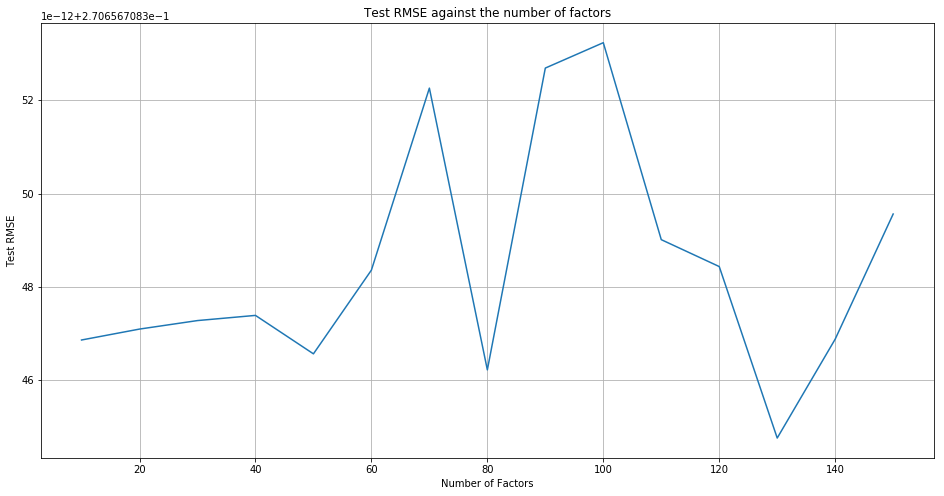

In [115]:
plt.plot(nnn_factors,test_loss_possible_rmse)
plt.title('Test RMSE against the number of factors')
plt.xlabel('Number of Factors')
plt.ylabel('Test RMSE')
plt.grid()
plt.savefig('svdtruetestrmserank.eps',format='eps')
# minimum at n_factors = 130.

In [185]:
# Set reg_all = 10, and n_factors = 130.
# Now let's do precision and recall.
algo = SVD(biased=True, n_epochs = 300,reg_all=10,n_factors=130)
algo.fit(trainset)
predictions = algo.test(testset, clip=False)
possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]

hihihihihihi


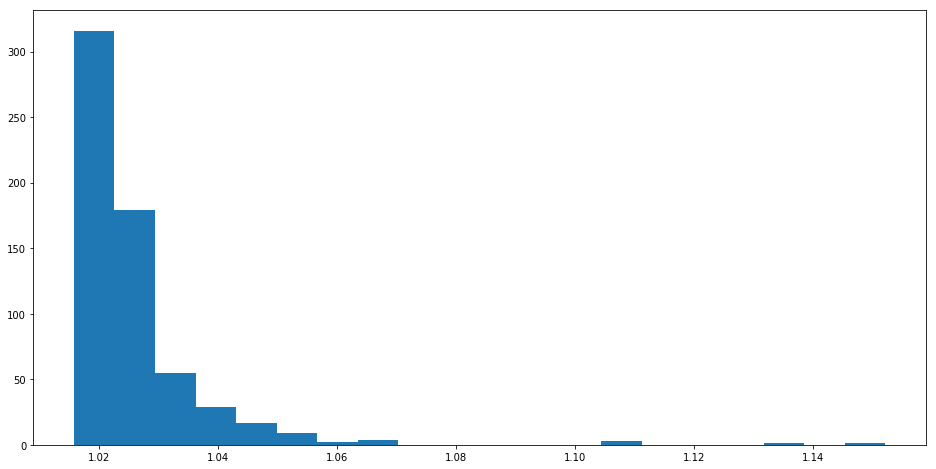

(1.0263324741843158,
 0.011981768667259361,
 1.1520969874947637,
 1.0158113897820824)

In [127]:
#Estimation distribution
"""
Estimation is a gaussian distribution.
Below is a histogram of estimations.
"""
estimations = []
for idx in range(len(possible_predictions)):
    estimations.append(possible_predictions[idx].est)

plt.hist(estimations,bins=20)
plt.show()

np.mean(estimations),np.std(estimations),max(estimations),min(estimations)

### 2.2 Prec&Rec 

In [117]:
# total ratings = 9507
U = 2879
I = 7937
est_mat = np.zeros((U,I))
for u in range(U):
    for i in range(I):
        est_mat[u][i] = algo.estimate(u,i)

In [128]:
users_testset = set()
for user,_,_ in testset:
    users_testset.add(user)
items_in_trainset_of_users_in_testset = defaultdict(list)
for user in users_testset:
    items_in_trainset_of_users_in_testset[trainset.to_inner_uid(user)] = trainset.ur[trainset.to_inner_uid(user)]
    
true_r = defaultdict(partial(defaultdict, int))
for user, paper, rating in testset:
    try:
        true_r[trainset.to_inner_uid(user)][trainset.to_inner_iid(paper)] = rating
    except ValueError:
        pass

In [152]:
k = 40
thresholds = np.linspace(1,1.04,40) #1.02?
precision_hist = np.zeros(len(thresholds))
recall_hist = np.zeros(len(thresholds))
f1_hist = np.zeros(len(thresholds))
for t,threshold in enumerate(thresholds):
    precisions_possible, recalls_possible = precision_recall_at_k(est_mat, items_in_trainset_of_users_in_testset, true_r, k=k, threshold=threshold)
    precision_hist[t] = sum(prec for prec in precisions_possible.values()) / len(precisions_possible)
    recall_hist[t] = sum(rec for rec in recalls_possible.values()) / len(recalls_possible)
    f1_hist[t] = 2*(precision_hist[t]*recall_hist[t])/(precision_hist[t]+recall_hist[t])

/Users/dae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


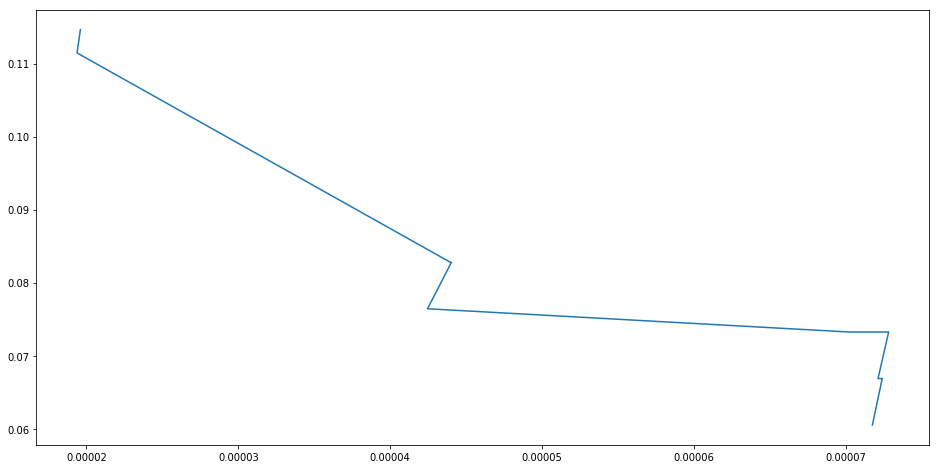

In [184]:
plt.plot(precision_hist,recall_hist)

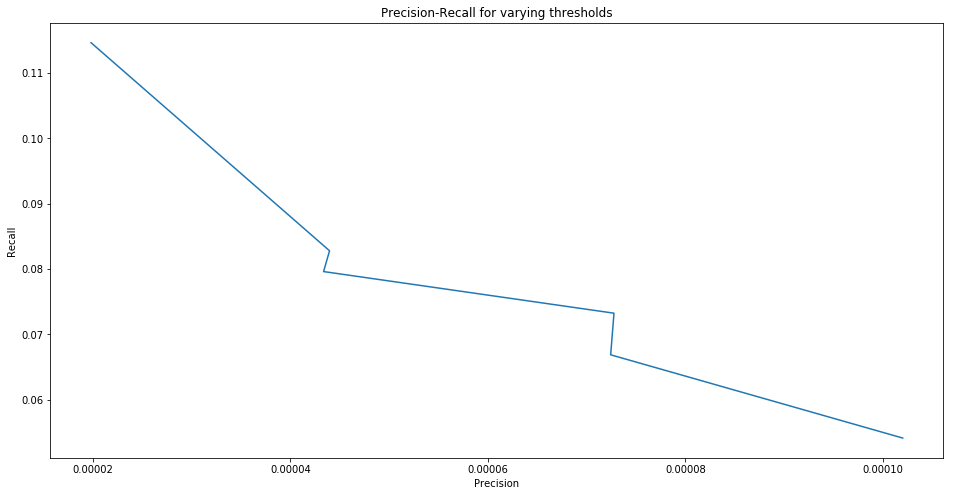

In [165]:
plt.plot(precision_hist[10:16],recall_hist[10:16])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall for varying thresholds')
# plt.savefig('svdtrueprecrec.eps',format='eps')

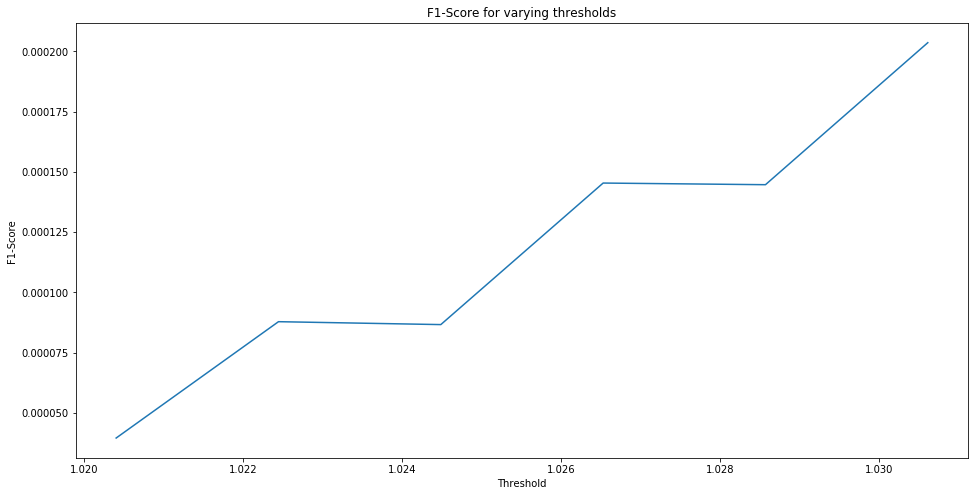

In [167]:
plt.plot(thresholds[10:16],f1_hist[10:16])
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score for varying thresholds')
# plt.savefig('svdtruef1score.eps',format='eps')

## 3. SVDpp
### 3.1 HyperParam. Search

In [2]:
random_dict = preprocess.create_random_subset_user_paper_data(size= 4000,debug=True)
trainset, testset = preprocess.user_paper_train_test_split(random_dict, test_size = .15)
rating_scale = (1,11)
trainset = preprocess.create_surprise_user_paper_data(trainset, rating_scale).build_full_trainset()
testset = preprocess.create_surprise_user_paper_data(testset, rating_scale).build_full_trainset().build_testset()

In [3]:
# Regularization Hyperparameter Search 1.
lambdas = 10.0**np.arange(-10,3)
test_loss_possible_rmse = np.zeros(len(lambdas))

for i in range(len(lambdas)):
    algo = SVDpp(n_epochs = 300,reg_all=lambdas[i],biased=False)
    algo.fit(trainset)
    predictions = algo.test(testset, clip=False)
    possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
    test_loss_possible_rmse[i] = accuracy.rmse(possible_predictions,verbose=False)

hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi


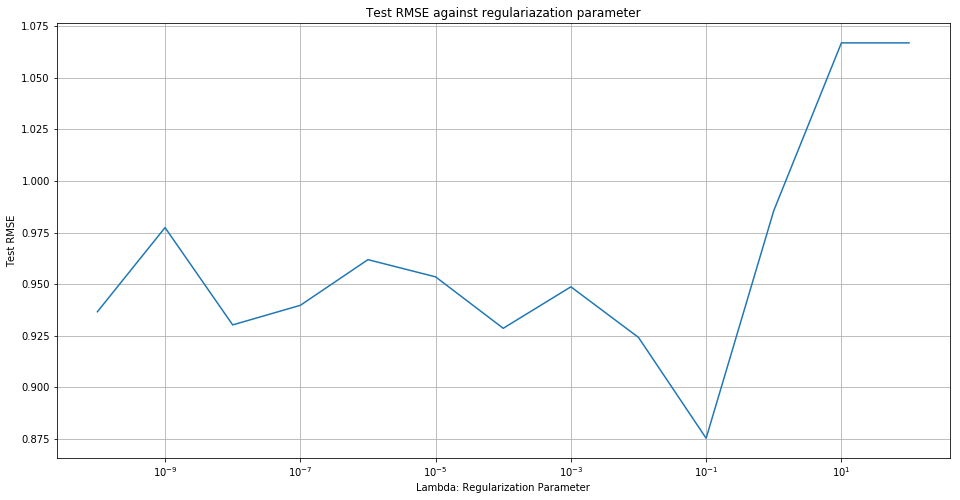

In [5]:
plt.semilogx(lambdas,test_loss_possible_rmse)
plt.title('Test RMSE against regulariazation parameter')
plt.xlabel('Lambda: Regularization Parameter')
plt.ylabel('Test RMSE')
plt.grid()
plt.savefig('svdpptestrmselambda.eps',format='eps')
# best lambda = 10^-1

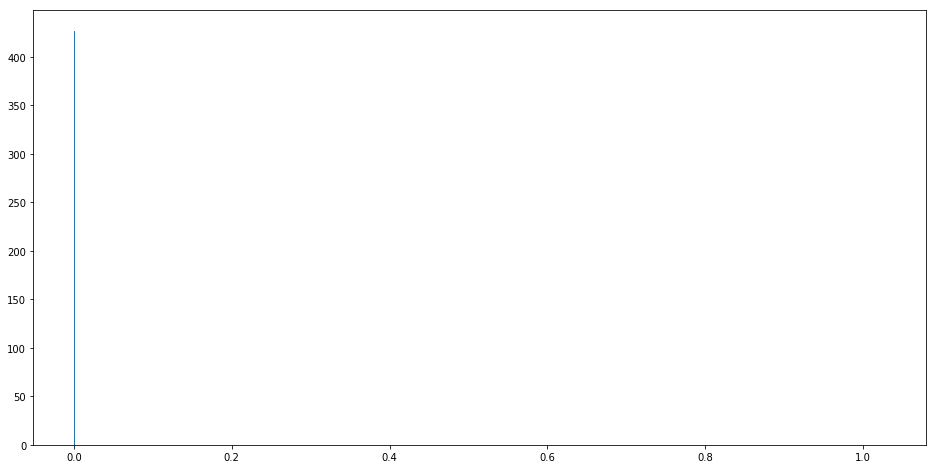

(0.23427306077932378,
 0.4312717554848475,
 1.0281984334203655,
 -7.4832769183e-313)

In [9]:
#Estimation distribution
"""
Estimation is a gaussian distribution.
Below is a histogram of estimations.
"""
estimations = []
for idx in range(len(predictions)):
    estimations.append(predictions[idx].est)

plt.hist(estimations,bins=1000)
plt.show()

np.mean(estimations),np.std(estimations),max(estimations),min(estimations)

In [10]:
# hyperparameter search 2: test rmse against rank
nnn_factors = np.linspace(10,150,15)
test_loss_possible_rmse = np.zeros(len(nnn_factors))

for i in range(len(nnn_factors)):
    algo = SVDpp(n_epochs = 200,reg_all=10**(-1),n_factors=int(nnn_factors[i]),biased=False)
    algo.fit(trainset)
    predictions = algo.test(testset, clip=False)
    possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
    test_loss_possible_rmse[i] = accuracy.rmse(possible_predictions,verbose=False)

hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi
hihihihihihi


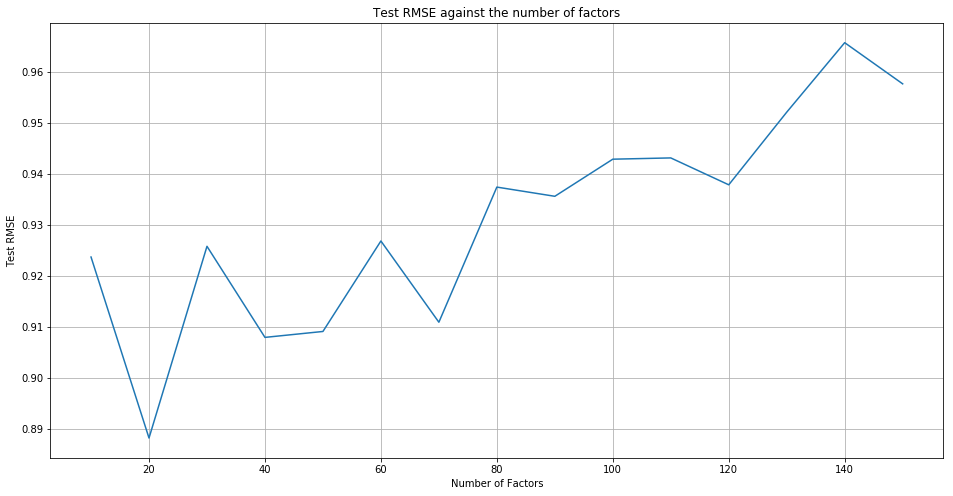

In [12]:
plt.plot(nnn_factors,test_loss_possible_rmse)
plt.title('Test RMSE against the number of factors')
plt.xlabel('Number of Factors')
plt.ylabel('Test RMSE')
plt.grid()
plt.savefig('svdpptestrmserank.eps',format='eps')
# minimum at n_factors = 20.

In [3]:
# Set reg_all = 10, and n_factors = 60.
# Now let's do precision and recall.
algo = SVDpp(n_epochs = 500,reg_all=10**(-1),n_factors=20,biased=False)
algo.fit(trainset)
predictions = algo.test(testset, clip=False)
possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]

hihihihihihi


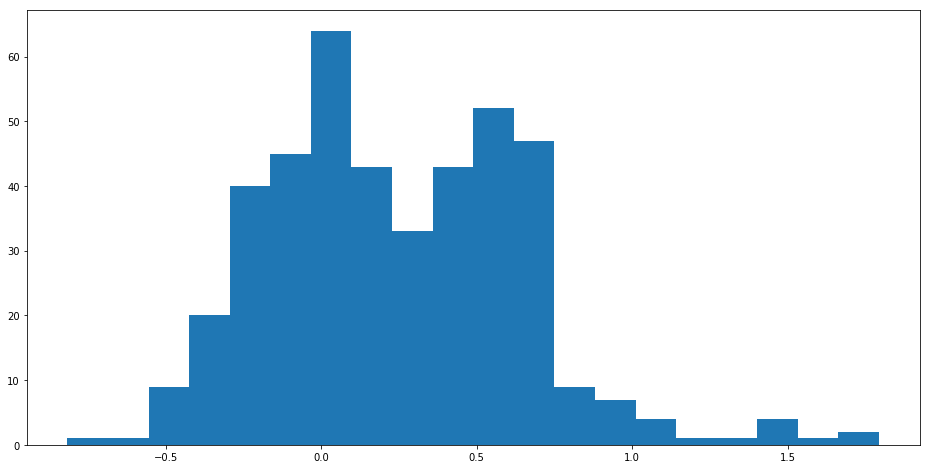

(0.2390072465616852,
 0.40770196948062404,
 1.794249663076734,
 -0.8157430989184276)

In [14]:
#Estimation distribution
"""
Estimation is a gaussian distribution.
Below is a histogram of estimations.
"""
estimations = []
for idx in range(len(possible_predictions)):
    estimations.append(possible_predictions[idx].est)

plt.hist(estimations,bins=20)
plt.show()

np.mean(estimations),np.std(estimations),max(estimations),min(estimations)

### 3.2 Prec&Rec 

In [9]:
# total ratings = 9507
U = 2914
I = 7936
est_mat = np.zeros((U,I))
for u in range(U):
    for i in range(I):
        est_mat[u][i] = algo.estimate(u,i)

In [10]:
users_testset = set()
for user,_,_ in testset:
    users_testset.add(user)
items_in_trainset_of_users_in_testset = defaultdict(list)
for user in users_testset:
    items_in_trainset_of_users_in_testset[trainset.to_inner_uid(user)] = trainset.ur[trainset.to_inner_uid(user)]
    
true_r = defaultdict(partial(defaultdict, int))
for user, paper, rating in testset:
    try:
        true_r[trainset.to_inner_uid(user)][trainset.to_inner_iid(paper)] = rating
    except ValueError:
        pass

In [29]:
k = 40
thresholds = np.linspace(0,0.6,50)
precision_hist = np.zeros(len(thresholds))
recall_hist = np.zeros(len(thresholds))
f1_hist = np.zeros(len(thresholds))
for t,threshold in enumerate(thresholds):
    precisions_possible, recalls_possible = precision_recall_at_k(est_mat, items_in_trainset_of_users_in_testset, true_r, k=k, threshold=threshold)
    precision_hist[t] = sum(prec for prec in precisions_possible.values()) / len(precisions_possible)
    recall_hist[t] = sum(rec for rec in recalls_possible.values()) / len(recalls_possible)
    f1_hist[t] = 2*(precision_hist[t]*recall_hist[t])/(precision_hist[t]+recall_hist[t])

In [15]:
k = 40
thresholds = np.linspace(0,0.6,10)
precision_hist = np.zeros(len(thresholds))
recall_hist = np.zeros(len(thresholds))
f1_hist = np.zeros(len(thresholds))
hmz_p_hist = np.zeros(len(thresholds))
hmz_r_hist = np.zeros(len(thresholds))
for t,threshold in enumerate(thresholds):
    precisions_possible, recalls_possible,hmz_p, hmz_r = precision_recall_at_k(est_mat, items_in_trainset_of_users_in_testset, true_r, k=k, threshold=threshold,how_many_zeros=True)
    precision_hist[t] = sum(prec for prec in precisions_possible.values()) / len(precisions_possible)
    recall_hist[t] = sum(rec for rec in recalls_possible.values()) / len(recalls_possible)
    f1_hist[t] = 2*(precision_hist[t]*recall_hist[t])/(precision_hist[t]+recall_hist[t])
    hmz_p_hist[t] = hmz_p/9507*100
    hmz_r_hist[t] = hmz_r/9507*100
    print(hmz_p,hmz_r)

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


In [14]:
hmz_p_hist

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Text(0.5,1,'Precision-Recall for varying thresholds')

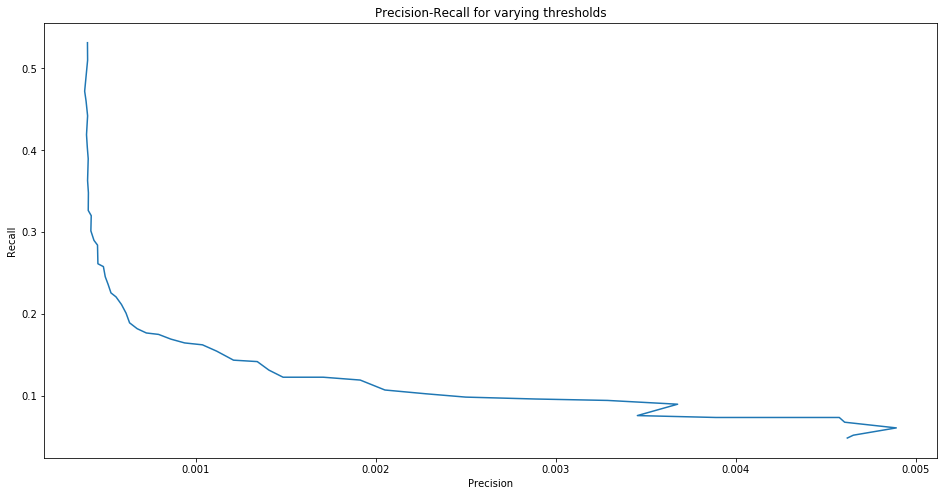

In [30]:
plt.plot(precision_hist,recall_hist)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall for varying thresholds')
# plt.savefig('svdppprecrec.eps',format='eps')


Text(0.5,1,'F1-Score for varying thresholds')

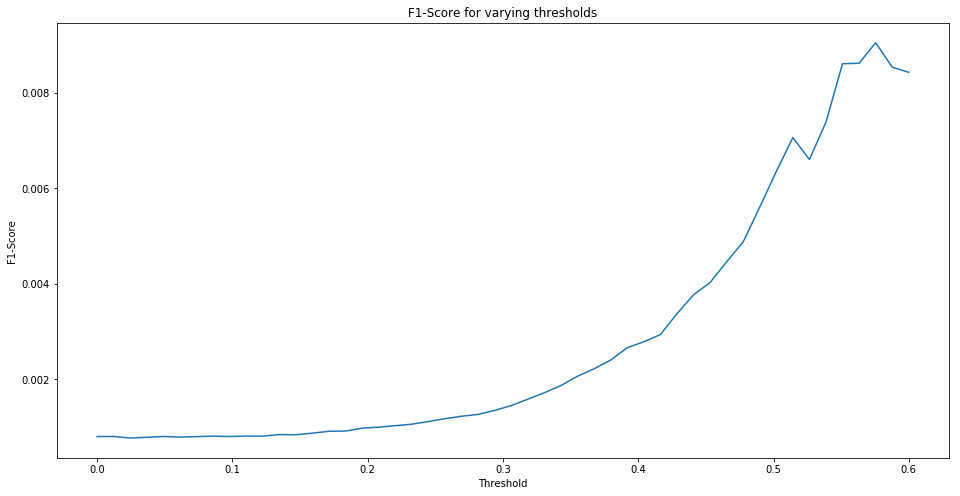

In [31]:
plt.plot(thresholds,f1_hist)
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score for varying thresholds')
# plt.savefig('svdppf1score.eps',format='eps')